# Introduction

The use of neocorticoids and other pesticides against insects is a growing problem because they are targeting not only the target insects which can act as pests but also useful ones like honey bees. There is a rapid decrease in the number of insects. Also it was shown before that insecticides can reduce the defense strength of the beehives against the [varroa mites](https://www.nature.com/articles/s41598-019-44207-1).
<br>
<br>
Without these insects the agriculture will lose a major contributor to the pollination of plants, which can lead to crop failures and famines. 70% of the 124 most important crops worldwide depend on pollination by insects. In Europe, the figure is as high as 84%. This fact makes the pollinating insects and with them the commercially used honey bees to one of the most if not the most important livestock. In Germany the honey bee is the third most used farm animal, right after cattle (1st place) and pigs (2nd place). In 2005, the estimated commercial value of western honey bees was just under 200 billion US-Dollars worldwide.
<br>
<br>
This is why I want to predict the health status of beehives based on a [kaggle dataset](https://www.kaggle.com/jenny18/honey-bee-annotated-images) that contains 5,100+ bee images annotated with location, date, time, subspecies, health condition, caste, and pollen. 
The first steps will be getting an overview about the dataset and how the different annotations of the pictures are distributed, then I want to build a basic classification models using supervised or unsupervised machine learning and then improve the prediction if possible with CNN and improving it. The final goal it will be to use GCP and Google Vision. The major challenges of this data set will be the different sizes and quality of the bee images and the testing of the model on beehive livestreams.
The success of this project will be defined by the accuracy of the detection of the health status of beehives in the real world and the usability for primary stakeholders like beekeepers. 

In [1]:
# Base Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
import scipy
import argparse
import plotly.graph_objects as go
import pgeocode
import plotly.express as px
from IPython.display import Image

# Image processing
import cv2
import imageio
import skimage
import skimage.io
import skimage.transform
from skimage.color import rgb2gray

# Tensorflow
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow


#Sklearn
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN as dbs
from sklearn.model_selection import GridSearchCV

RSEED=42
bee_imgs = "../capstone_working/bee_imgs/bee_imgs/"
sns.set(font='sans-serif', font_scale=1)

# Bee Data Health Status

| Variable | Definition | Key |
|---|---|---|
| datetime | Date of the Measurment | Year-Month-Day Hour:Minute:Second|
|file| Filename of the Image| filename.png|
|location|Location of the Beehive |City, State, Country |
|zip code| Zipcode of the City|- |
|subspecies| Subspecies of the Honey Bee| Italian, Russian, Carniolan, Mixed, -1, VSH Italian, Western|
|health| Health Status of the Beehive| Varroa mites and Hive Beetles, Healthy, Hive Being Robbed, Ant Problems, Missing Queen|
|pollen_carrying| Boolean if the Honey Bee on the Image is carrying Pollen| False or True|
|caste| Caste of the Honey Bee on the Image| Caste (in this case only workers)|

In [2]:
bee_data = pd.read_csv('../capstone_working/bee_data.csv',
                       parse_dates={'datetime': [1, 2]},
                       dtype={'subspecies': 'category','health': 'category','caste': 'category'})

In [3]:
bee_data.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [4]:
bee_data.columns = bee_data.columns.str.replace(' ', '_')

# EDA for the Bee images for Health detection

In [5]:
bee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 8 columns):
datetime           5172 non-null datetime64[ns]
file               5172 non-null object
location           5172 non-null object
zip_code           5172 non-null int64
subspecies         5172 non-null category
health             5172 non-null category
pollen_carrying    5172 non-null bool
caste              5172 non-null category
dtypes: bool(1), category(3), datetime64[ns](1), int64(1), object(2)
memory usage: 182.5+ KB


In [6]:
bee_data.describe()

,zip_code
count,5172.000000
mean,68599.910480
std,27101.954146
min,3431.000000
25%,50315.000000
50%,77511.000000
75%,95070.000000
max,95124.000000


### Looking at health and subspecies

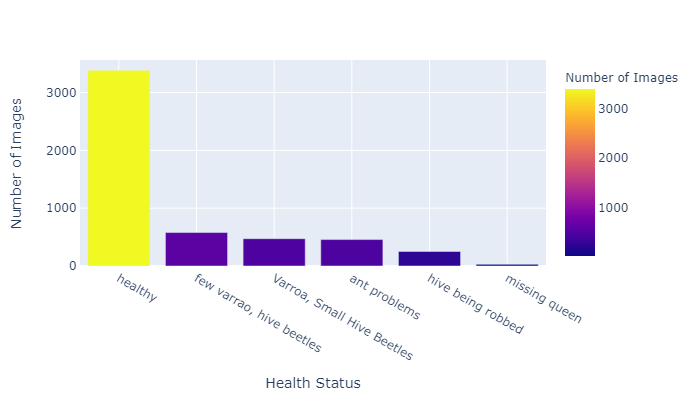

In [7]:
bee_data_health = bee_data.health.value_counts()
fig = px.bar(bee_data_health, y='health',
             hover_data=['health'], color='health',
             labels={'health':'Number of Images', 'index': 'Health Status'}, height=400)
#fig.show()
fig.write_image("plots/fig1.png")
Image("plots/fig1.png")

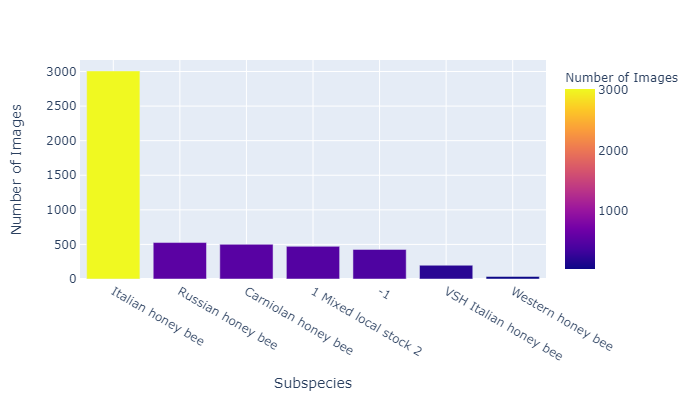

In [8]:
bee_data_sub = bee_data.subspecies.value_counts()
fig = px.bar(bee_data_sub, y='subspecies',
             hover_data=['subspecies'], color='subspecies',
             labels={'subspecies':'Number of Images', 'index': 'Subspecies'}, height=400)
#fig.show()
fig.write_image("plots/fig2.png")
Image("plots/fig2.png")

### Looking at the caste of the bees

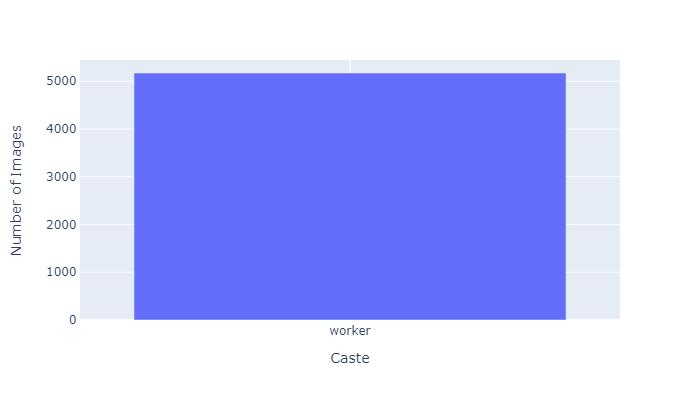

In [9]:
bee_data_caste = bee_data.caste.value_counts()
fig = px.bar(bee_data_caste, y='caste',
             hover_data=['caste'],
             labels={'caste':'Number of Images', 'index': 'Caste'}, height=400)
#fig.show()
fig.write_image("plots/fig3.png")
Image("plots/fig3.png")

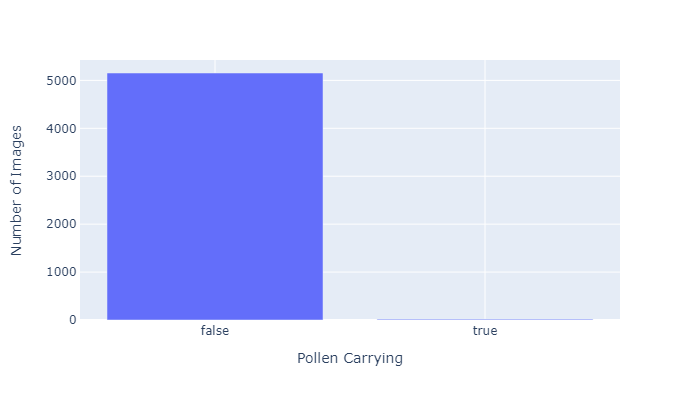

In [10]:
bee_data_pollen = bee_data.pollen_carrying.value_counts()
fig = px.bar(bee_data_pollen, y='pollen_carrying',
             hover_data=['pollen_carrying'],
             labels={'pollen_carrying':'Number of Images', 'index': 'Pollen Carrying'}, height=400)
#fig.show()
fig.write_image("plots/fig4.png")
Image("plots/fig4.png")

### Creating Dummies

In [11]:
bee_data_dum = bee_data.copy()

#### Subspecies

In [12]:
subspecies_dummies = pd.get_dummies(bee_data_dum.subspecies, drop_first=True)

In [13]:
subspecies_dummies.columns = subspecies_dummies.columns.str.replace(' ', '_')

#### Pollen Carrying

In [14]:
pollen_dummies = pd.get_dummies(bee_data_dum.pollen_carrying, drop_first=True, prefix = 'pollen_')

#### Health

In [15]:
health_dummies = pd.get_dummies(bee_data_dum.health, drop_first=True)

In [16]:
health_dummies.columns = health_dummies.columns.str.replace(' ', '_')

In [17]:
health_dummies.missing_queen.value_counts()

0    5143
1      29
Name: missing_queen, dtype: int64

In [18]:
health_dummies.hive_being_robbed.value_counts()

0    4921
1     251
Name: hive_being_robbed, dtype: int64

#### Location

In [19]:
location_dummies = pd.get_dummies(bee_data_dum.location, drop_first=True)

In [20]:
location_dummies.columns = location_dummies.columns.str.replace(' ', '_')

#### zip code

In [21]:
zip_dummies = pd.get_dummies(bee_data_dum.zip_code, drop_first=True)

#### caste

In [22]:
caste_dummies = pd.get_dummies(bee_data_dum.caste)

#### Create new data frame with dummies

In [23]:
drop_columns = [
    'health', 'subspecies', 'pollen_carrying', 'caste', 'location', 'zip_code'
]
bee_data_dum.drop(drop_columns, axis=1, inplace=True)

In [24]:
bee_data_dum = pd.concat([
    bee_data_dum, health_dummies, pollen_dummies, subspecies_dummies,
    caste_dummies, zip_dummies, location_dummies
],
                         axis=1)
bee_data_dum.head()

,datetime,file,ant_problems,"few_varrao,_hive_beetles",healthy,hive_being_robbed,missing_queen,pollen__True,1_Mixed_local_stock_2,Carniolan_honey_bee,...,77511,95070,95124,"Athens,_GA,_USA","Athens,_Georgia,_USA","Des_Moines,_IA,_USA","Keene,_NH,_USA","New_Orleans,_LA,_USA","San_Jose,_CA,_USA","Saratoga,_CA,_USA"
0,2018-08-28 16:07:00,041_066.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2018-08-28 16:07:00,041_072.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2018-08-28 16:07:00,041_073.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,2018-08-28 16:07:00,041_067.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2018-08-28 16:07:00,041_059.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Heatmaps

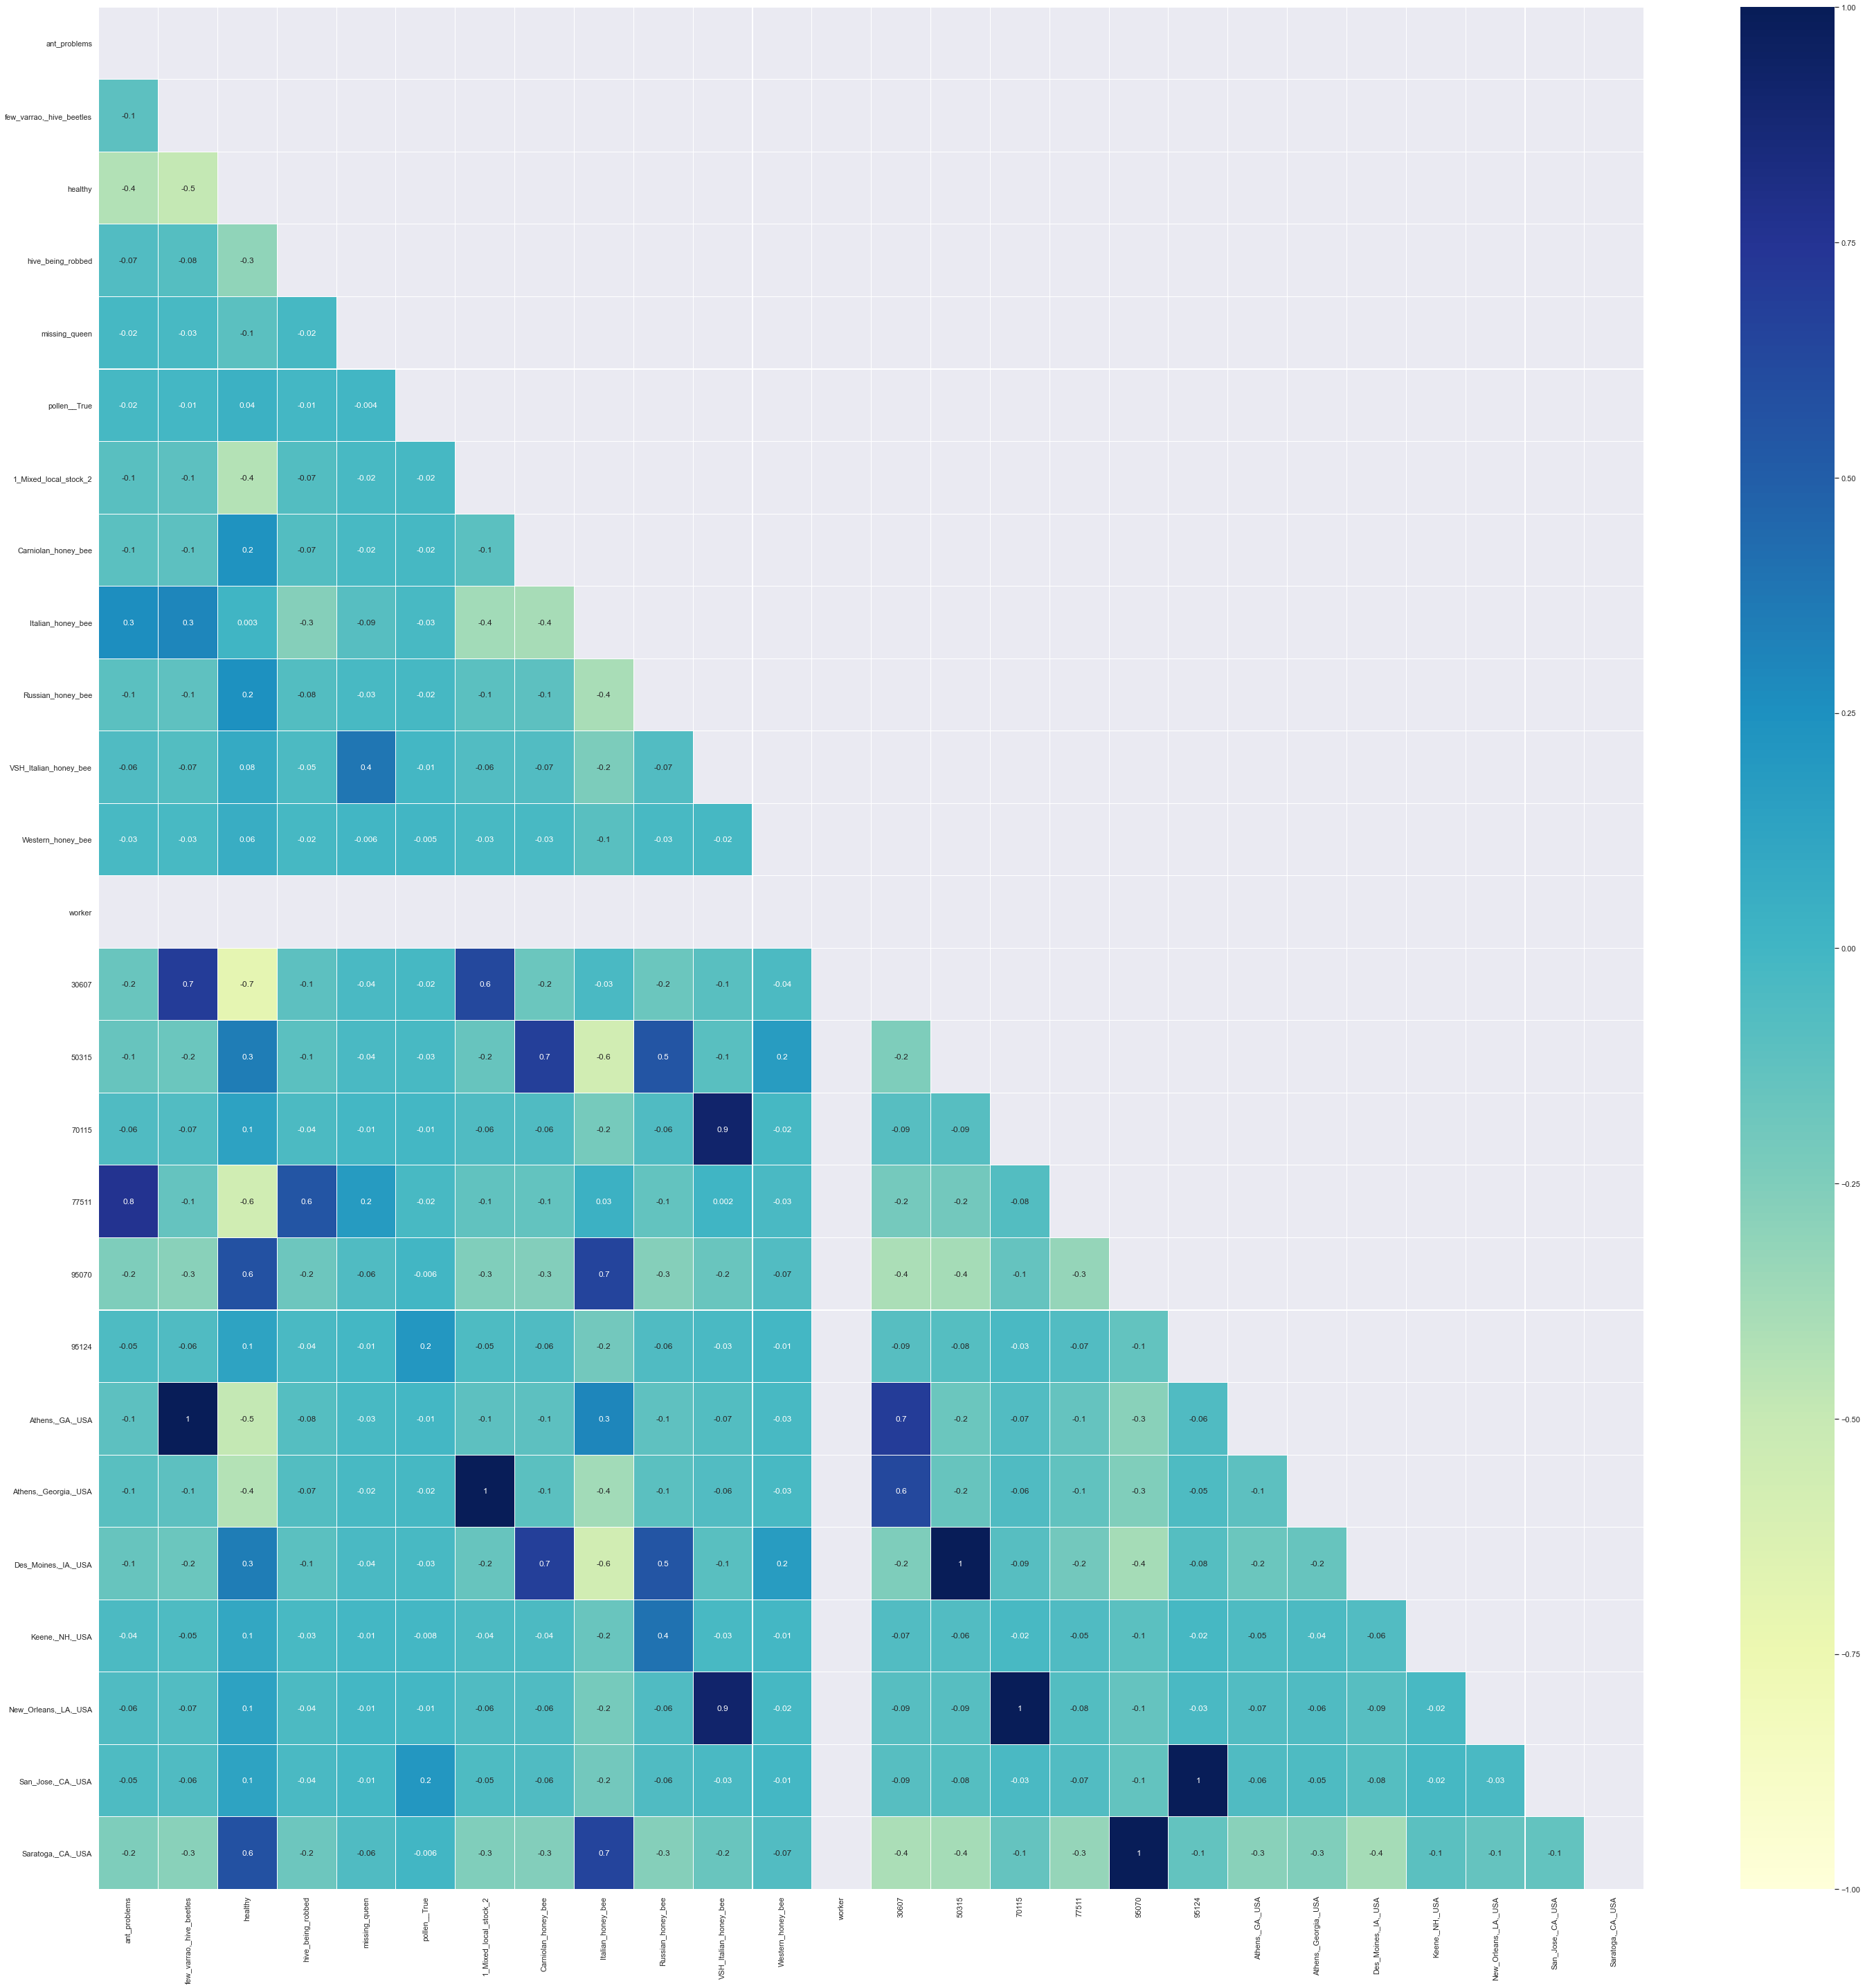

In [25]:
matrix = np.triu(bee_data_dum.corr())
plt.subplots(figsize=(50, 50))
sns.heatmap(bee_data_dum.corr(),
            mask=matrix,
            annot=True,
            fmt='.1g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap='YlGnBu',
            linewidth=.1);

## Feature engineering

Adding more Info to the location 

In [26]:
idx_lst = []
zip_lst = []
zip_data = pgeocode.Nominatim('us')
for idx, zip in bee_data.zip_code.iteritems():
    idx_lst.append(idx)
    zip_lst.append(str(zip))
zip_data = zip_data.query_postal_code(zip_lst)

In [27]:
zip_data.drop(['county_code', 'community_name', 'community_code', 'accuracy'],axis=1, inplace=True)

In [28]:
zip_data.columns = zip_data.columns.str.replace(' ', '_')

In [29]:
zip_data.head()

,postal_code,country_code,place_name,state_name,state_code,county_name,latitude,longitude
0,77511,US,Alvin,Texas,TX,Brazoria,29.412,-95.2515
1,77511,US,Alvin,Texas,TX,Brazoria,29.412,-95.2515
2,77511,US,Alvin,Texas,TX,Brazoria,29.412,-95.2515
3,77511,US,Alvin,Texas,TX,Brazoria,29.412,-95.2515
4,77511,US,Alvin,Texas,TX,Brazoria,29.412,-95.2515


In [30]:
bee_data.drop(['location', 'zip_code'], axis=1, inplace=True)

In [31]:
bee_data = pd.concat([
    bee_data, zip_data
],
                         axis=1)

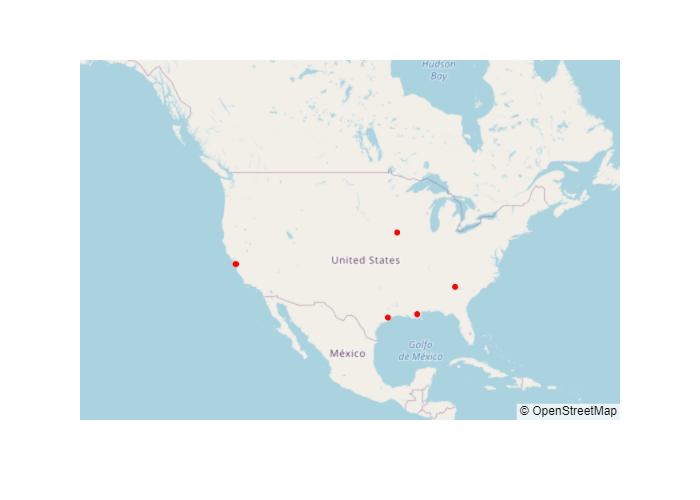

In [32]:
fig = px.scatter_mapbox(bee_data,
                        lat="latitude",
                        lon="longitude",
                        color_discrete_sequence= ['red'],
                        center=dict(lat=40.55, lon=-101.91),
                        zoom=2
                        )
fig.update_layout(mapbox_style="open-street-map") 
#fig.show()
fig.write_image("plots/fig5.png")
Image("plots/fig5.png")

The categories 'few varrao, hive beetles' and 'Varroa, small hive beetles' in the column 'health' both detect Varroa mites and Hive beetles. That's why they will be combined in the next steps.

In [33]:
bee_data.health.unique()

[hive being robbed, healthy, few varrao, hive beetles, ant problems, missing queen, Varroa, Small Hive Beetles]
Categories (6, object): [hive being robbed, healthy, few varrao, hive beetles, ant problems, missing queen, Varroa, Small Hive Beetles]

In [34]:
new_cat = {
    'few varrao, hive beetles': 'varroa and hive beetles',
    'Varroa, Small Hive Beetles': 'varroa and hive beetles'
}

bee_data.health.replace(new_cat, inplace=True)

In [35]:
bee_data.health.astype('category', inplace=True).dtype

CategoricalDtype(categories=['ant problems', 'healthy', 'hive being robbed',
                  'missing queen', 'varroa and hive beetles'],
                 ordered=False)

Only 29 entries have 'missing queen' as health status, because I doubt that a missing queen can be detected in images of single bees I will drop those.

In [36]:
index_num = bee_data[bee_data['health'] == 'missing queen'].index

In [37]:
bee_data.drop(index_num , inplace=True)

## Looking at the pictures

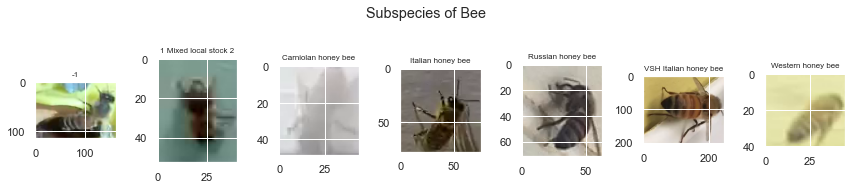

In [38]:
subspecies = bee_data['subspecies'].cat.categories
f, ax = plt.subplots(nrows=1, ncols=subspecies.size, figsize=(12, 3))
i = 0
for s in subspecies:
    if s == 'healthy':
        continue
    file = bee_imgs + bee_data[bee_data['subspecies'] == s].iloc[0]['file']
    im = imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i += 1

plt.suptitle("Subspecies of Bee")
plt.tight_layout()
plt.show()

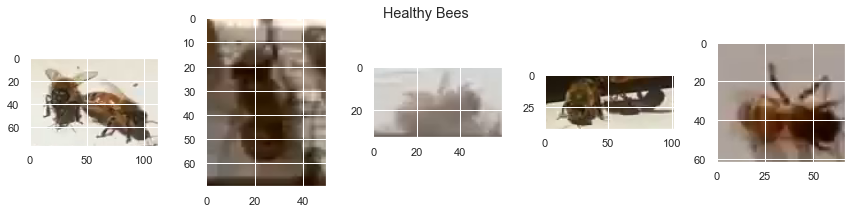

In [39]:
n = 5
healthy = bee_data[bee_data['health'] == 'healthy'].sample(n)

f, ax = plt.subplots(nrows=1, ncols=n, figsize=(12, 3))
# Read image of original size from disk, because bees['img'] contains resized numpy array
for i in range(0, 5):
    file = bee_imgs + healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))

plt.suptitle("Healthy Bees")
plt.tight_layout()
plt.show()

In [40]:
health_cats = set()
for d in bee_data.health:
    health_cats.add(d)

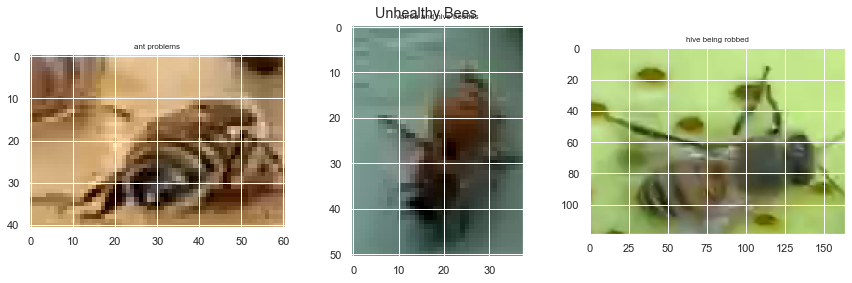

In [41]:
f, ax = plt.subplots(1, len(health_cats) - 1, figsize=(12, 4))
i = 0
for c in health_cats:
    if c == 'healthy':
        continue
    bee_img = bee_data[bee_data['health'] == c].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(bee_imgs + bee_img['file']))
    ax[i].set_title(bee_img['health'], fontsize=8)
    i += 1

plt.suptitle("Unhealthy Bees")
plt.tight_layout()
plt.show()

### Images are of different sizes

In [42]:
def resize_img(file):
    """
    Read and resize img, adjust channels.
    """
    img = skimage.io.imread(bee_imgs + file)
    img = skimage.transform.resize(img, (100, 100), mode='reflect')
    img = rgb2gray(img[:, :, :3])
    img = img.flatten()
    return img

# Base model

Splitting the Data into Train- and Testsets.

In [43]:
train_bee, test_bee = train_test_split(bee_data, random_state=RSEED)

X_train = np.stack(train_bee['file'].apply(resize_img)) 
y_train  = train_bee['health']
y_test  = test_bee['health']
X_test = np.stack(test_bee['file'].apply(resize_img))

Create a pipline with PCA and the used model SVM.

In [44]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Run a GridSearch with Crossvalidation.

In [45]:
param_grid = {
    'svc__C': [1, 5, 10, 50],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]
}
grid = GridSearchCV(model,
                    param_grid,
                    cv=10,
                    verbose=5,
                    scoring='f1_weighted',
                    n_jobs=-1)
%time grid.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  4.5min finished


Wall time: 4min 35s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 5, 10, 50],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]},
             scoring='f1_weighted', verbose=5)

In [46]:
best_param = grid.best_params_
best_param

{'svc__C': 50, 'svc__gamma': 0.005}

In [47]:
best_model = grid.best_estimator_

Predict the Categories of the Testimages with the best Model based on the Gridsearch.

In [48]:
y_pred = best_model.predict(X_test)

In [49]:
ytest = y_test.to_numpy()

In [50]:
right = y_pred == ytest

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

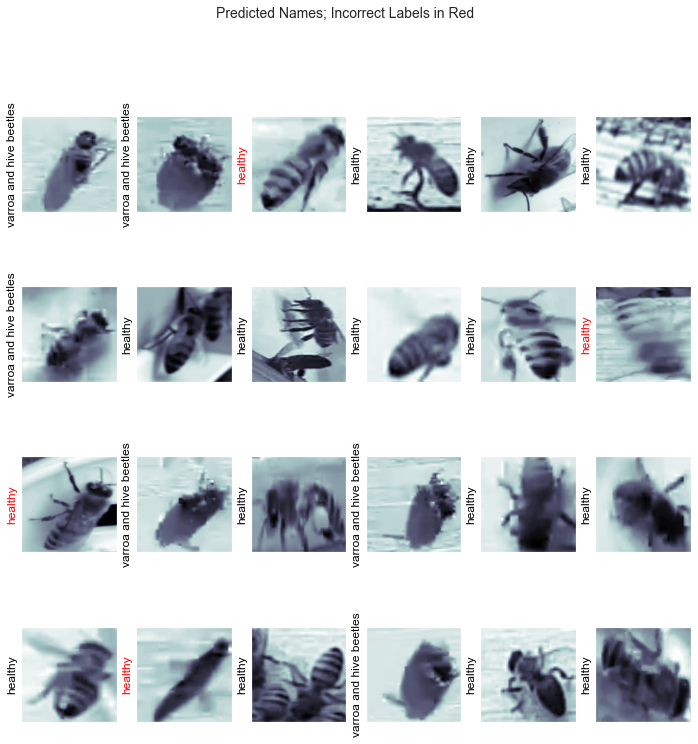

In [51]:
fig, ax = plt.subplots(4, 6, figsize=(12, 12))
counter = 0
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(100, 100), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(y_pred[i], color='black' if right[i] else 'red')

fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred));

                         precision    recall  f1-score   support

           ant problems       0.88      0.39      0.54       110
                healthy       0.83      0.97      0.89       845
      hive being robbed       0.38      0.05      0.09        59
varroa and hive beetles       0.90      0.82      0.86       272

               accuracy                           0.84      1286
              macro avg       0.75      0.56      0.60      1286
           weighted avg       0.83      0.84      0.82      1286



The base model achieved an accuracy rate of 84% but the recall score of the prediction for the categories 'ant problems' and 'hive being robbed' are very low. Therefore I decided to make a additional neural network.  

# Convulutional Neural Network (CNN)

Before we can run a neural network we have to balance the data.

In [53]:
g = bee_data.copy()
ncat_bal = int(len(bee_data) / len(health_cats))
g = pd.DataFrame(g.groupby('health', as_index=False).apply(lambda g: g.sample(ncat_bal, replace=True)).reset_index(drop=True))
g.health.value_counts()

varroa and hive beetles    1285
healthy                    1285
ant problems               1285
hive being robbed          1285
Name: health, dtype: int64

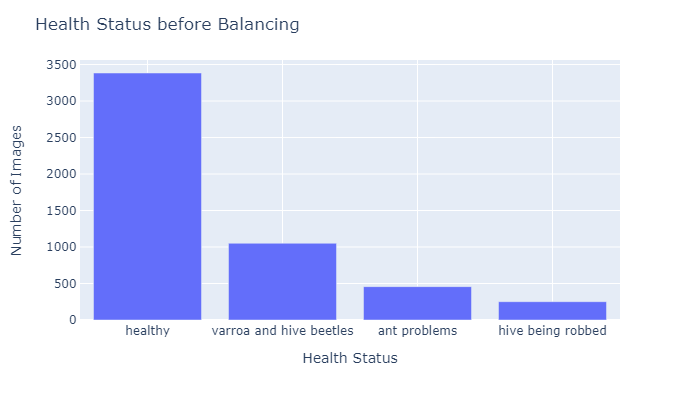

In [54]:
fig = px.bar(bee_data.health.value_counts(), y='health',
         hover_data=['health'],
         labels={'health':'Number of Images', 'index': 'Health Status'}, height=400)
fig.update_layout(title_text='Health Status before Balancing')
#fig.show()
fig.write_image("plots/fig6.png")
Image("plots/fig6.png")

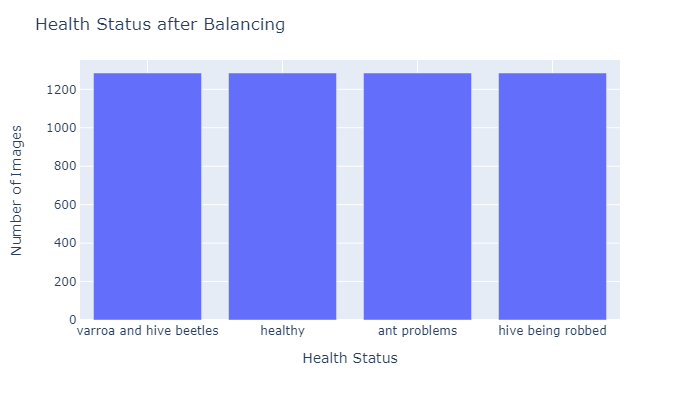

In [55]:
fig1 = px.bar(g.health.value_counts(), y='health',
         hover_data=['health'],
         labels={'health':'Number of Images', 'index': 'Health Status'}, height=400)
fig1.update_layout(title_text='Health Status after Balancing')
#fig1.show()
fig1.write_image("plots/fig7.png")
Image("plots/fig7.png")

Import and resize the images

In [56]:
data = []
categories = []
# loop over the image paths
for idx in g.index:
    cat = g.health[idx]
    image = cv2.imread(bee_imgs + g.file[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image/255


    data.append(image)
    categories.append(cat)

Split the data into Train- and Testsets and binarize the categories.

In [57]:
# convert the data and labels to NumPy arrays
data = np.array(data)
categories = np.array(categories)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
categories = lb.fit_transform(categories)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(X_train, X_test, y_train, y_test) = train_test_split(data, categories,
    test_size=0.25, stratify=categories, random_state=RSEED)

Split the Trainset into Train and Validation

In [58]:
(X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn) = train_test_split(X_train, y_train,
    test_size=0.15, random_state=RSEED)

Augmentation for the Images to prevent overfitting especially because of the oversampling in the balancing step.

In [59]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the validation/testing data augmentation object
valAug = ImageDataGenerator()

Creat our Convulutional Neural Network (CNN):

In [60]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(128, 128 ,3)),
    MaxPooling2D(2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(2),
    Conv2D(64, 3, padding='same', activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


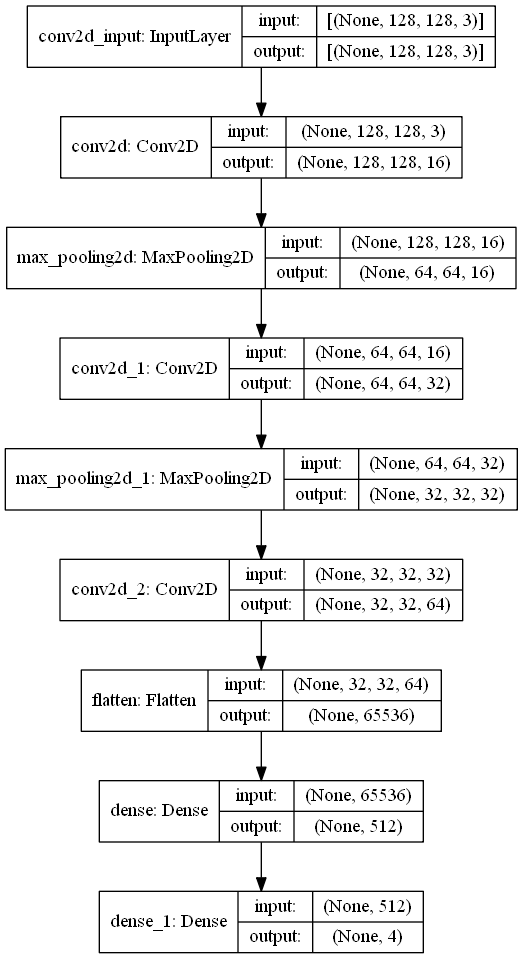

In [61]:
plot_model(model, show_shapes=True)

In [62]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [63]:
training = model.fit(trainAug.flow(X_train_cnn,y_train_cnn, batch_size=64),
                        epochs=15,
                        steps_per_epoch=40,
                        validation_data=valAug.flow(X_val_cnn, y_val_cnn),
                        callbacks = [early_stop]
         )

Epoch 1/15
40/40 [==============================] - 17s 426ms/step - loss: 1.6132 - acc: 0.4781 - val_loss: 0.6091 - val_acc: 0.7841
Epoch 2/15
40/40 [==============================] - 16s 390ms/step - loss: 0.4163 - acc: 0.8488 - val_loss: 0.2900 - val_acc: 0.9050
Epoch 3/15
40/40 [==============================] - 15s 379ms/step - loss: 0.2502 - acc: 0.9169 - val_loss: 0.2289 - val_acc: 0.9171
Epoch 4/15
40/40 [==============================] - 16s 398ms/step - loss: 0.1796 - acc: 0.9348 - val_loss: 0.1737 - val_acc: 0.9344
Epoch 5/15
40/40 [==============================] - 16s 393ms/step - loss: 0.1322 - acc: 0.9474 - val_loss: 0.1402 - val_acc: 0.9551
Epoch 6/15
40/40 [==============================] - 16s 391ms/step - loss: 0.1542 - acc: 0.9438 - val_loss: 0.2019 - val_acc: 0.9119
Epoch 7/15
40/40 [==============================] - 16s 409ms/step - loss: 0.1370 - acc: 0.9523 - val_loss: 0.0776 - val_acc: 0.9741
Epoch 8/15
40/40 [==============================] - 16s 409ms/step - 

In [64]:
y_pred_cnn = model.predict(X_test)

In [65]:
def visualize_layer_kernels(img, conv_layer, title):
    """
    Displays how input sample image looks after convolution by each kernel.
    """
    # Extract kernels from given layer
    weights1 = conv_layer.get_weights()
    kernels = weights1[0]
    kernels_num = kernels.shape[3]

    # Each row contains 3 images: kernel, input image, output image
    f, ax = plt.subplots(kernels_num, 3, figsize=(7, kernels_num * 2))

    for i in range(0, kernels_num):
        # Get kernel from the layer and draw it
        kernel = kernels[:, :, :3, i]
        ax[i][0].imshow((kernel * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][0].set_title("Kernel %d" % i, fontsize=9)

        # Get and draw sample image from test data
        ax[i][1].imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][1].set_title("Before", fontsize=8)

        # Filtered image - apply convolution
        img_filt = scipy.ndimage.filters.convolve(img, kernel)
        ax[i][2].imshow((img_filt * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][2].set_title("After", fontsize=8)

    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

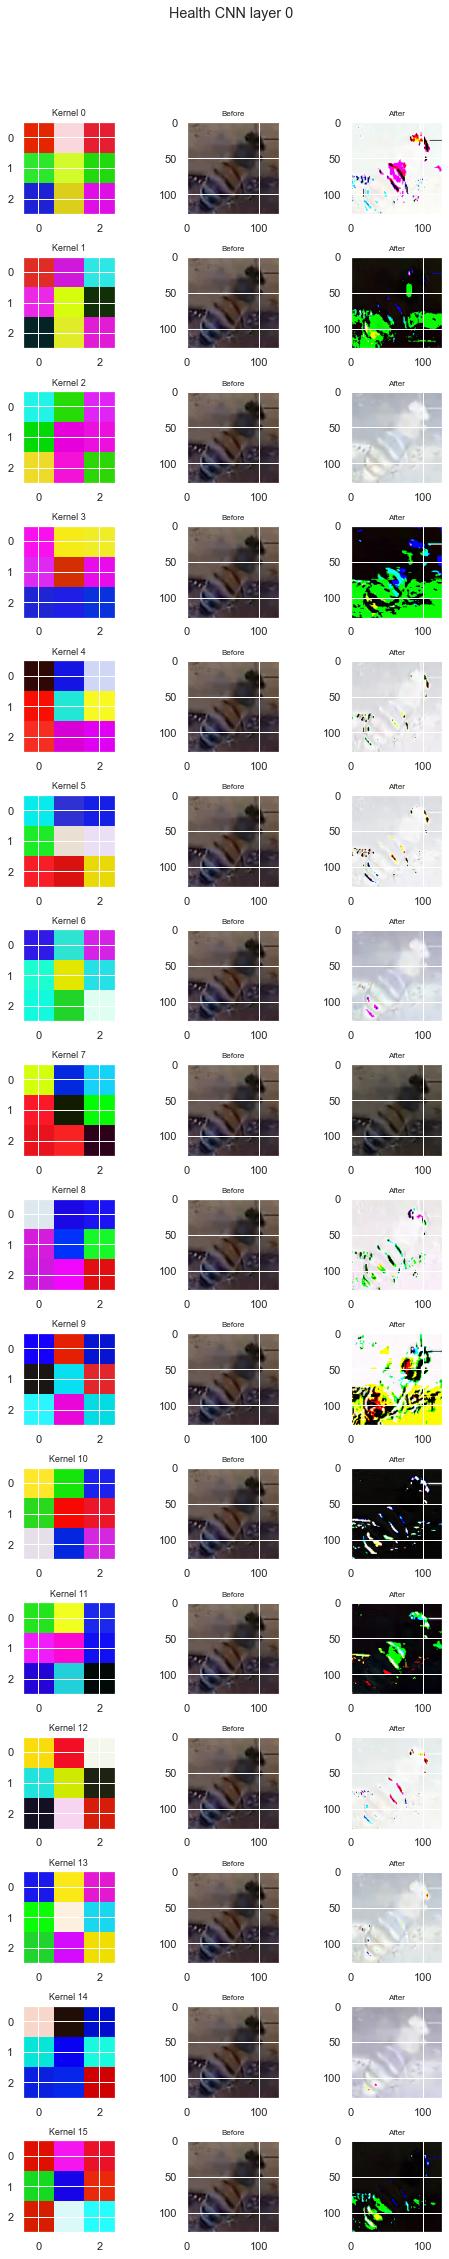

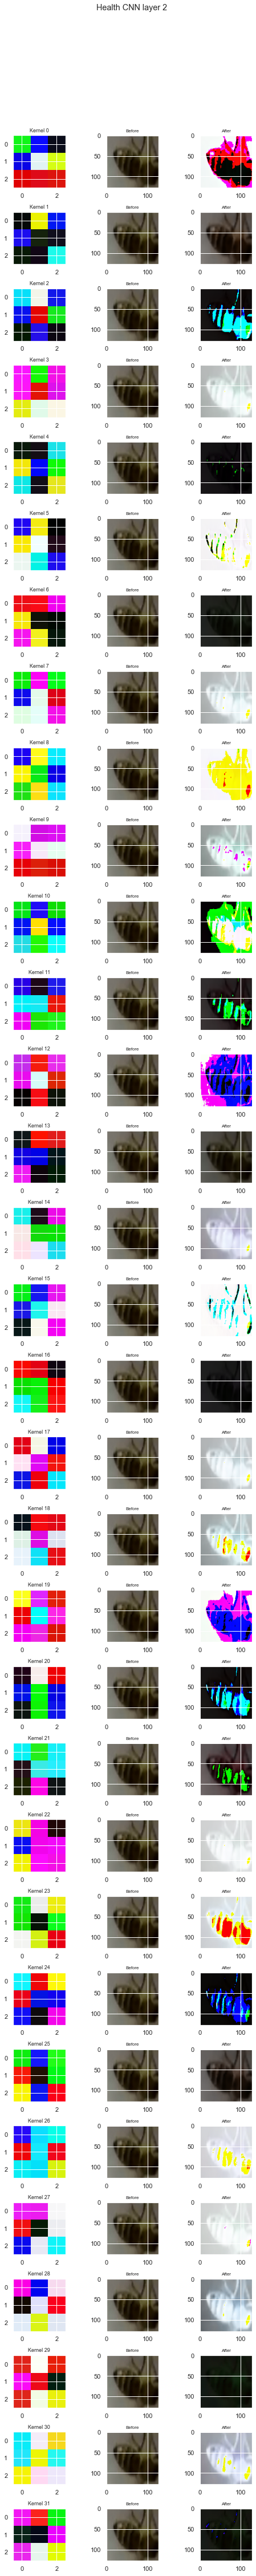

In [66]:
# Take sample image to visualize convolution
idx = random.randint(0,len(X_test)-1)
img = X_test[idx,:,:,:]
#img = img[:,:,:]
# Take 1st convolutional layer and look at it's filters
conv1 = model.layers[0]
visualize_layer_kernels(img, conv1, "Health CNN layer 0")

# Take sample image to visualize convolutoin
idx = random.randint(0,len(X_test)-1)
img = X_test[idx,:,:,:]
# Take another convolutional layer and look at it's filters
conv2 = model.layers[2]
visualize_layer_kernels(img, conv2, "Health CNN layer 2")

In [67]:
def eval_model(training, model, test_X, test_y, field_name):
    """
    Model evaluation: plots, classification report
    @param training: model training history
    @param model: trained model
    @param test_X: features 
    @param test_y: labels
    @param field_name: label name to display on plots
    """
    ## Trained model analysis and evaluation
    f, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Accuracy
    ax[1].plot(training.history['acc'], label="Accuracy")
    ax[1].plot(training.history['val_acc'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    # Accuracy by subspecies
    test_pred = model.predict(test_X)

    #acc_by_subspecies = np.logical_and(
    #    (test_pred > 0.5), test_y).sum() / test_y.sum()
    #acc_by_subspecies.plot(kind='bar', title='Accuracy by %s' % field_name)
    #plt.ylabel('Accuracy')
    #plt.show()

    # Print metrics
    print("Classification report")
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(test_y, axis=1)
    print(
        metrics.classification_report(test_truth,
                                      test_pred,
                                      target_names=health_cats))

    # Loss function and accuracy
    test_res = model.evaluate(test_X, test_y, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

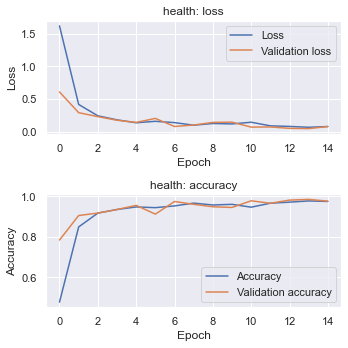

Classification report
                         precision    recall  f1-score   support

           ant problems       1.00      0.99      0.99       321
                healthy       0.93      1.00      0.96       322
varroa and hive beetles       0.99      0.98      0.99       321
      hive being robbed       1.00      0.95      0.97       321

               accuracy                           0.98      1285
              macro avg       0.98      0.98      0.98      1285
           weighted avg       0.98      0.98      0.98      1285

Loss function: 0.05614349234129885, accuracy: 0.97898835


In [68]:
eval_model(training, model, X_test, y_test, 'health')

The CNN achieved a accuracy rate of 95% and got overall much better scores than the Base Model.

In [69]:
y_pred = model.predict(X_test)
test_truth = np.argmax(y_test, axis=1)
y_pred_final = np.argmax(y_pred, axis=1)
right_cnn = y_pred_final == test_truth
health_cats

{'ant problems', 'healthy', 'hive being robbed', 'varroa and hive beetles'}

In [70]:
classes_dic = {
    0: "Ant Problem",
    1: 'Healthy',
    2: 'Hive Beeing Robbed',
    3: 'Varroa Mites or Hive Beetles'
}

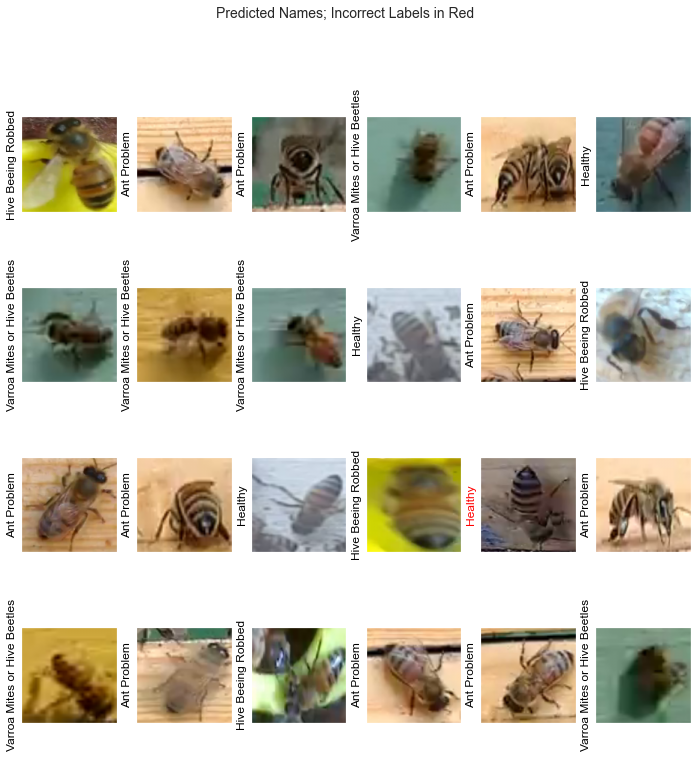

In [71]:
fig, ax = plt.subplots(4, 6, figsize=(12, 12))
counter = 0
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i], cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(classes_dic[y_pred_final[i]],
                   color='black' if right_cnn[i] else 'red')

fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

# Conclusion

- [x] Cleaned and balanced the data.
- [x] Made a decent Base Model. 
- [x] Created a CNN that exceeds the Base Model. 
- [x] Moved into the Google Cloud. 
- [x] Created a Google Vision Model.
- [ ] Installed a live tracking device of Temperature and Humidity. 
- [ ] Created an app for detecting the health status of beehives with GCP


The main goal the make a model that predicts the health status of beehives was fullfilled. The **Convolutional Neural Network** that I created predicts the test images with an **accuracy of 98%**. That means the model is right in 98% of the cases.  

# Future Work
Implementing an Object Detection Model in GCP to predict live stream images of beehives and track the humidity and temperature of the beehives with a graphical interface.